# DISPLAY MAPS

## Display sea ice statistics maps in the Weddell Sea using .nc files
- Read netCDF files for the sea ice statistics
- Draw sea ice statistics maps in the Weddell Sea

Credited by Younghyun Koo (kooala317@gmail.com)

## (1) Import necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, glob
import numpy as np
import h5py

import matplotlib.pylab as plt
from math import *
import time
import pandas as pd
import datetime as dt
from tqdm import tqdm
import geopandas
import json
from datetime import datetime, timedelta
from scipy import stats
from scipy.ndimage import gaussian_filter1d

import pickle

%load_ext autoreload
%autoreload 2
from functions_floes import *

In [4]:
%matplotlib notebook

## Accuracy assessment

In [4]:
year = 2019
th_fb = 0.8
th_sigma = 0.02
th_std = 0.1
df_all = pd.read_csv(f"D:\\Floes\\icebergs\\Icebergs_Weddell_2019_fb{th_fb}_sigma{th_sigma}_std{th_std}.csv", index_col = 0)

bbox = [-62, -77.6, -15, -62]

In [2]:
df_all.head(5)

NameError: name 'df_all' is not defined

In [5]:
df_count = df_all.groupby(["filename", "beam"]).sum()
files = df_count.sort_values(by = "width", ascending = False).loc[:, ['lat']].head(30).index.unique().sort_values()

In [6]:
files

MultiIndex([('ATL10-02_20190310110421_11000201_006_02.h5', 'gt1l'),
            ('ATL10-02_20190310110421_11000201_006_02.h5', 'gt2l'),
            ('ATL10-02_20190310110421_11000201_006_02.h5', 'gt3l'),
            ('ATL10-02_20190310220423_11070201_006_02.h5', 'gt1l'),
            ('ATL10-02_20190310220423_11070201_006_02.h5', 'gt2l'),
            ('ATL10-02_20190310220423_11070201_006_02.h5', 'gt3l'),
            ('ATL10-02_20190502085018_05210301_006_02.h5', 'gt1l'),
            ('ATL10-02_20190518191658_07720301_006_02.h5', 'gt2l'),
            ('ATL10-02_20190518191658_07720301_006_02.h5', 'gt3l'),
            ('ATL10-02_20190522190837_08330301_006_02.h5', 'gt1l'),
            ('ATL10-02_20190522190837_08330301_006_02.h5', 'gt2l'),
            ('ATL10-02_20190522190837_08330301_006_02.h5', 'gt3l'),
            ('ATL10-02_20190530185156_09550301_006_02.h5', 'gt1l'),
            ('ATL10-02_20190621061857_12830301_006_02.h5', 'gt3l'),
            ('ATL10-02_20190727160357_04520401_0

## Draw profiles

In [97]:
n = 20
filename = "D:\\Floes\\ATL10\\" + "ATL10-02_20191019003453_03380501_006_02.h5" #"ATL10-02_20191005125113_01320501_006_02.h5"
#"ATL10-02_20190518191658_07720301_006_02.h5"
# "ATL10-02_20190502085018_05210301_006_02.h5"
# "ATL10-02_20190518191658_07720301_006_02.h5" #files[n][0]
beam = "gt3r" #files[n][1]
# beam_nums = df_all.loc[df_all['filename'] == files[n], "beam_num"].unique()
print(filename, beam)

D:\Floes\ATL10\ATL10-02_20191019003453_03380501_006_02.h5 gt3r


In [171]:
# th_fb = 0.8
# th_sigma = 0.02
# th_std = 0.1
ib_filtering = False

with h5py.File(filename,'r') as f:
    # print(filename)
    # Check the orbit orientation

    df_raw = read_ATL10(filename, bbox)
    df = df_raw.loc[df_raw['beam']==beam, :].reset_index(drop = True)
    # df['fb_mode'] = smooth_line(df['fb_mode'].values, df['seg_x'].values, 5000) #gaussian_filter1d(df['fb_mode'], 100)

    # th_fb2 = np.where(df['fb_mode']+0.6 > th_fb, df['fb_mode']+0.6, th_fb)
    ib_mask2, df_ib = determine_iceberg(df, th_fb, th_sigma, th_std)
    df_ib2, ib_mask3 = combine_icebergs(df, df_ib, ib_mask2, th_fb = 0.8)
    df['ib_mask'] = ib_mask3.astype(int)

    if ib_filtering:
        df = df[ib_mask3 == 0].reset_index(drop = True)
    ######################################################
    lat = df['lat'].values
    lon = df['lon'].values
    seg_x = df['seg_x'].values
    seg_len = df['seg_len'].values
    fb = df['fb'].values
    stype = df['stype'].values
    refsur_ndx = df['refsur_ndx'].values

    freeboard_mode, sample_ndx = modal_profile(fb, seg_x, refsur_ndx)

    ridge = np.zeros(np.shape(fb))
    # Ridge or not? (threshold 0.6 m above level (mode) freeboard)
    ridge[fb > freeboard_mode + 0.6] = 1

    df['fb_mode'] = freeboard_mode
    df['ridge'] = ridge

print(filename)

D:\Floes\ATL10\ATL10-02_20191019003453_03380501_006_02.h5


In [99]:
df.head(5)

,beam,lat,lon,seg_x,seg_len,fb,ph_rate,sigma,stype,refsur_ndx,sample_ndx,fb_std,fb_mode,ridge,ib_mask
0,gt3r,-72.077646,-52.451976,0.000000,135.100296,0.246028,0.689119,0.018688,1,58,580.0,NaN,0.19,0.0,0
1,gt3r,-72.077149,-52.452200,56.049407,116.738739,0.211471,0.862275,0.016088,1,58,580.0,0.037005,0.19,0.0,0
2,gt3r,-72.076682,-52.452412,109.032145,123.272453,0.172072,0.900000,0.017077,1,58,580.0,0.032010,0.19,0.0,0
3,gt3r,-72.076219,-52.452623,161.432728,108.631348,0.148072,1.044444,0.011387,7,58,580.0,0.019332,0.19,0.0,0
4,gt3r,-72.075921,-52.452757,194.913790,64.197334,0.186324,1.586957,0.012107,7,58,580.0,0.027292,0.19,0.0,0


D:\Floes\ATL10\ATL10-02_20191019003453_03380501_006_02.h5 38 4964


Text(0.5, -7.277777777777782, 'Along-track distance (km)')

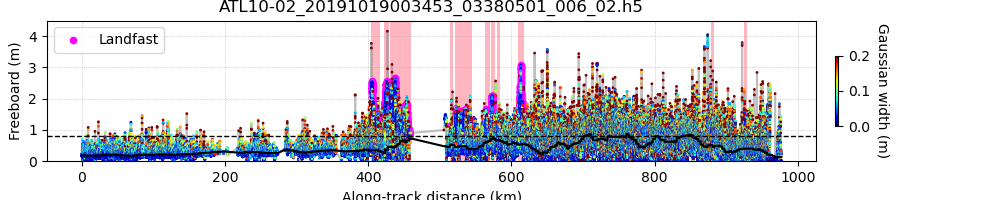

In [100]:
%matplotlib widget
print(filename, len(df_ib2), sum(ib_mask3))
fig, ax = plt.subplots(1,1, figsize = (10, 2), dpi = 100, sharex = True)
fig.tight_layout()

# pm = ax.pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax.plot(df['seg_x']/1000, df['fb'], c="gray", zorder=1, alpha = 0.5)
ax.plot(df['seg_x']/1000, df['fb_mode'], c="k", zorder=10)
sc = ax.scatter(df['seg_x']/1000, df['fb'], c=df['fb_std'], s= 1, cmap = "jet", vmax = 0.2, zorder = 2) # std. freeboard nearby

# sc = ax.scatter(seg_x[ib_mask], fb[ib_mask], s= 2, c = "yellow", zorder = 6) # std. freeboard nearby
ax.scatter(df['seg_x'][ib_mask3]/1000, df['fb'][ib_mask3], s= 20, c = "magenta", zorder = 1, marker = "o", label = "Landfast") # std. freeboard nearby
# sc = ax.scatter(seg_x[ib_mask3]/1000 - seg_min, fb[ib_mask3]*0 + 4.2, s= 20, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax.scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma

# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax.axhline(th_fb, ls = "--", lw = 1, c="k", zorder=2)
# ax.plot(df['seg_x']/1000, th_fb, c="k")
ax.vlines(df['seg_x'][ib_mask3]/1000, 0, 5, color="lightpink", zorder = 0, alpha = 0.5, lw = 2)

cb = fig.colorbar(sc, pad = 0.02, shrink = 0.5)
cb.set_label(f"Gaussian width (m)", rotation = 270, va = "bottom")

ax.set_title(os.path.basename(filename))
ax.grid(ls = ":", lw = 0.5)

ax.set_ylabel("Freeboard (m)");

ax.set_ylim(0, 4.5);

ax.legend()

ax.set_xlabel("Along-track distance (km)")

# ax.set_xlim(5, 10)
# plt.savefig("D:\\Documents\\Submit_paper\\Landfast_Weddell\\Miss_detection.png", bbox_inches = "tight")

# ax.set_xlim(469, 474)
# plt.savefig("D:\\Documents\\Submit_paper\\Landfast_Weddell\\Wrong_detection.png", bbox_inches = "tight")
# plt.close()

In [185]:
idx = df['sample_ndx'] == 1101
# plt.figure()
# plt.scatter(df['seg_x'][idx], df['fb'][idx])
df[(df['seg_x'] < 437000) & (df['seg_x'] > 434000)]

,beam,lat,lon,seg_x,seg_len,fb,ph_rate,sigma,stype,refsur_ndx,sample_ndx,fb_std,fb_mode,ridge,ib_mask
37269,gt3r,-68.218432,-53.905277,434000.151373,11.418455,0.953596,8.647058,0.019233,1,102,1020.0,0.154706,0.438571,0.0,0
37270,gt3r,-68.218372,-53.905296,434006.891996,12.848978,0.702173,7.736842,0.020519,1,102,1020.0,0.214654,0.438571,0.0,0
37271,gt3r,-68.218315,-53.905315,434013.310604,12.135353,0.526523,7.611111,0.015624,1,102,1020.0,0.111847,0.438571,0.0,0
37272,gt3r,-68.218269,-53.905330,434018.427402,11.421791,0.494391,8.176471,0.014767,1,102,1020.0,0.051977,0.438571,0.0,0
37273,gt3r,-68.218215,-53.905347,434024.522981,12.849936,0.596075,7.777778,0.021989,1,102,1020.0,0.219681,0.438571,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37778,gt3r,-68.191937,-53.913853,436976.457739,11.300635,2.240454,8.176471,0.009469,1,102,1020.0,0.050878,0.438571,1.0,1
37779,gt3r,-68.191880,-53.913872,436982.826239,12.001076,2.169795,8.500000,0.010112,1,102,1020.0,0.049540,0.438571,1.0,1
37780,gt3r,-68.191837,-53.913887,436987.633244,10.592900,2.144973,9.125000,0.010279,1,102,1020.0,0.012799,0.438571,1.0,1
37781,gt3r,-68.191792,-53.913902,436992.689203,11.297157,2.162802,8.411765,0.009251,1,102,1020.0,0.011830,0.438571,1.0,1


In [113]:
def calculate_mode2(data):

    w = 0.02
    M = 4
    m = w 
    
    kde = KernelDensity(bandwidth=w*5, kernel='gaussian')
    kde.fit(data[:, None])
    x_d = np.arange(m, M, w)
    logprob = kde.score_samples(x_d[:, None])
    n_max = np.argmax(np.exp(logprob))
    mode = x_d[n_max] + w/2

    return x_d, logprob, mode

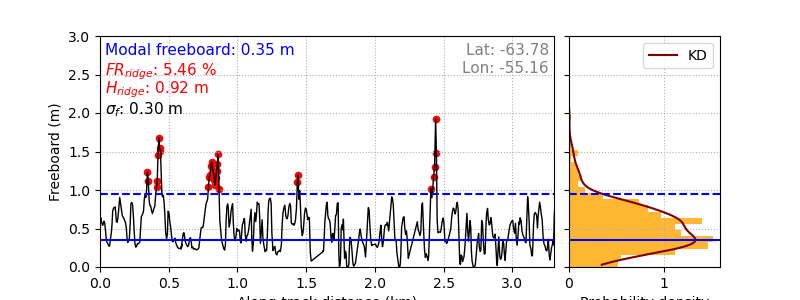

In [168]:
filename = "D:\\Floes\\ATL10\\" + "ATL10-02_20191019003453_03380501_006_02.h5"
beam = "gt3r" 
w = 0.02
df = read_ATL10(filename, bbox)

for N in [1502]: #1502

    fig, ax = plt.subplots(1,2, figsize = (8, 3), dpi = 100, gridspec_kw={'width_ratios': [3, 1]}, sharey = True)
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    
    idx = (df['beam'] == beam) & (df['sample_ndx'] == N) # 140
    
    data = df['fb'][idx].values
    x_d, logprob, mode = calculate_mode2(data)
    
    idx_ridge = idx & (df['ridge'] == 1)
    x_min = np.min(df['seg_x'][idx]/1000)
    ax[0].plot(df['seg_x'][idx]/1000 - x_min, df['fb'][idx], color = 'k', lw = 1)
    ax[0].plot(df['seg_x'][idx]/1000 - x_min, df['seg_x'][idx]*0 + mode, color = "b")
    ax[0].plot(df['seg_x'][idx]/1000 - x_min, df['seg_x'][idx]*0 + mode + 0.6, color = "b", ls = "--")
    ax[0].scatter(df['seg_x'][idx_ridge]/1000 - x_min, df['fb'][idx_ridge], color = "r", s = 20)
    ax[0].set_xlim(0, 3.3)
    ax[0].set_xlabel('Along-track distance (km)')
    ax[0].set_ylabel('Freeboard (m)')
    ax[0].grid(ls = ":", lw = 0.8)
    ax[0].annotate(f"Modal freeboard: {mode:.2f} m", xy = (0.01, 0.97), xycoords='axes fraction',
                   ha = "left", va = "top", fontsize = 11, color = "b")
    
    # ax[0].annotate(f"Mode: {mode}", xy = (0.01, 0.90), xycoords='axes fraction', ha = "left", va = "top", fontsize = 11)
    
    rf = np.sum(df['seg_len'][idx_ridge]) / np.sum(df['seg_len'][idx]) * 100
    rh = np.mean(df['fb'][idx_ridge]) - mode
    sdf = np.std(df['fb'][idx])
    pos_lat = np.mean(df['lat'][idx])
    pos_lon = np.mean(df['lon'][idx])
    
    ax[0].annotate("$FR_{ridge}$" + f": {rf:.2f} %", xy = (0.01, 0.89), xycoords='axes fraction',
                   ha = "left", va = "top", fontsize = 11, color = "r")
    ax[0].annotate("$H_{ridge}$" + f": {rh:.2f} m", xy = (0.01, 0.81), xycoords='axes fraction',
                   ha = "left", va = "top", fontsize = 11, color = "r")
    ax[0].annotate("$\sigma_{f}$" + f": {sdf:.2f} m", xy = (0.01, 0.72), xycoords='axes fraction',
                   ha = "left", va = "top", fontsize = 11, color = "k")

    ax[0].annotate("Lat" + f": {pos_lat:.2f}", xy = (0.99, 0.97), xycoords='axes fraction',
                   ha = "right", va = "top", fontsize = 11, color = "gray")
    ax[0].annotate("Lon" + f": {pos_lon:.2f}", xy = (0.99, 0.89), xycoords='axes fraction',
                   ha = "right", va = "top", fontsize = 11, color = "gray")
    
    ax[1].hist(data, density = True, range = (0,4), bins = 50, orientation = "horizontal", color = "orange", alpha = 0.8)
    ax[1].plot(np.exp(logprob), x_d + w/2, color = "maroon", label = "KD")
    ax[1].axhline(mode, color = "b")
    ax[1].axhline(mode + 0.6, color = "b", ls = "--")
    ax[1].set_ylim(0, 3.0)
    ax[1].set_xlabel('Probability density')
    ax[1].grid(ls = ":", lw = 0.8)
    ax[1].legend()

    prf_name = os.path.basename(filename).replace('_006_02.h5', beam + str(int(N)) + ".png")
    plt.savefig("D:\\Documents\\Submit_paper\\Landfast_Weddell\\{0}.png".format(prf_name), bbox_inches="tight")

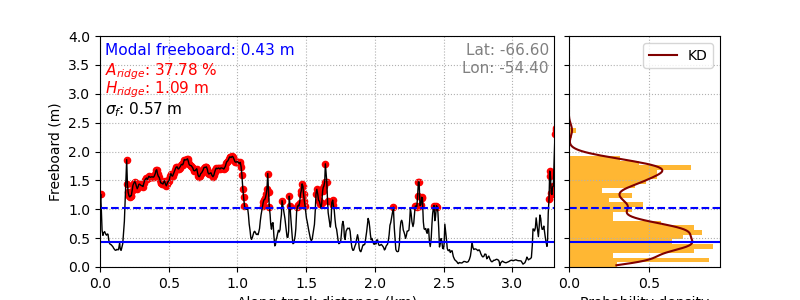

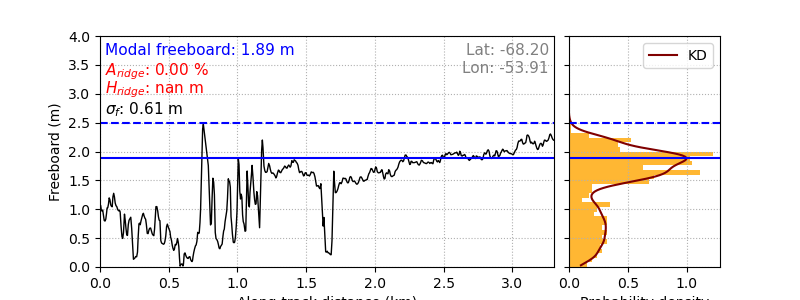

In [206]:
filename = "D:\\Floes\\ATL10\\" + "ATL10-02_20191019003453_03380501_006_02.h5"
beam = "gt3r" 
w = 0.02
# dF = read_ATL10(filename, bbox)

for N in [1190, 1020]:

    fig, ax = plt.subplots(1,2, figsize = (8, 3), dpi = 100, gridspec_kw={'width_ratios': [3, 1]}, sharey = True)
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    
    idx = (df['beam'] == beam) & (df['sample_ndx'] == N) # 140
    
    data = df['fb'][idx].values
    x_d, logprob, mode = calculate_mode2(data)
    
    idx_ridge = idx & (df['fb'] > mode + 0.6)
    x_min = np.min(df['seg_x'][idx]/1000)
    ax[0].plot(df['seg_x'][idx]/1000 - x_min, df['fb'][idx], color = 'k', lw = 1)
    ax[0].plot(df['seg_x'][idx]/1000 - x_min, df['seg_x'][idx]*0 + mode, color = "b")
    ax[0].plot(df['seg_x'][idx]/1000 - x_min, df['seg_x'][idx]*0 + mode + 0.6, color = "b", ls = "--")
    ax[0].scatter(df['seg_x'][idx_ridge]/1000 - x_min, df['fb'][idx_ridge], color = "r", s = 20)
    ax[0].set_xlim(0, 3.3)
    ax[0].set_xlabel('Along-track distance (km)')
    ax[0].set_ylabel('Freeboard (m)')
    ax[0].grid(ls = ":", lw = 0.8)
    ax[0].annotate(f"Modal freeboard: {mode:.2f} m", xy = (0.01, 0.97), xycoords='axes fraction',
                   ha = "left", va = "top", fontsize = 11, color = "b")
    
    # ax[0].annotate(f"Mode: {mode}", xy = (0.01, 0.90), xycoords='axes fraction', ha = "left", va = "top", fontsize = 11)
    
    rf = np.sum(df['seg_len'][idx_ridge]) / np.sum(df['seg_len'][idx]) * 100
    rh = np.mean(df['fb'][idx_ridge]) - mode
    sdf = np.std(df['fb'][idx])
    pos_lat = np.mean(df['lat'][idx])
    pos_lon = np.mean(df['lon'][idx])
    
    ax[0].annotate("$A_{ridge}$" + f": {rf:.2f} %", xy = (0.01, 0.89), xycoords='axes fraction',
                   ha = "left", va = "top", fontsize = 11, color = "r")
    ax[0].annotate("$H_{ridge}$" + f": {rh:.2f} m", xy = (0.01, 0.81), xycoords='axes fraction',
                   ha = "left", va = "top", fontsize = 11, color = "r")
    ax[0].annotate("$\sigma_{f}$" + f": {sdf:.2f} m", xy = (0.01, 0.72), xycoords='axes fraction',
                   ha = "left", va = "top", fontsize = 11, color = "k")

    ax[0].annotate("Lat" + f": {pos_lat:.2f}", xy = (0.99, 0.97), xycoords='axes fraction',
                   ha = "right", va = "top", fontsize = 11, color = "gray")
    ax[0].annotate("Lon" + f": {pos_lon:.2f}", xy = (0.99, 0.89), xycoords='axes fraction',
                   ha = "right", va = "top", fontsize = 11, color = "gray")
    
    ax[1].hist(data, density = True, range = (0,4), bins = 50, orientation = "horizontal", color = "orange", alpha = 0.8)
    ax[1].plot(np.exp(logprob), x_d + w/2, color = "maroon", label = "KD")
    ax[1].axhline(mode, color = "b")
    ax[1].axhline(mode + 0.6, color = "b", ls = "--")
    ax[1].set_ylim(0, 4.0)
    ax[1].set_xlabel('Probability density')
    ax[1].grid(ls = ":", lw = 0.8)
    ax[1].legend()

    prf_name = os.path.basename(filename).replace('_006_02.h5', beam + str(int(N)) + ".png")
    plt.savefig("D:\\Documents\\Submit_paper\\Landfast_Weddell\\{0}.png".format(prf_name), bbox_inches="tight")

In [120]:
df

,beam,lat,lon,seg_x,seg_len,fb,ph_rate,sigma,stype,refsur_ndx,sample_ndx,fb_std,fb_mode,ridge,ib_mask
0,gt3r,-72.077646,-52.451976,0.000000,135.100296,0.246028,0.689119,0.018688,1,58,580.0,NaN,0.19,0.0,0
1,gt3r,-72.077149,-52.452200,56.049407,116.738739,0.211471,0.862275,0.016088,1,58,580.0,0.037005,0.19,0.0,0
2,gt3r,-72.076682,-52.452412,109.032145,123.272453,0.172072,0.900000,0.017077,1,58,580.0,0.032010,0.19,0.0,0
3,gt3r,-72.076219,-52.452623,161.432728,108.631348,0.148072,1.044444,0.011387,7,58,580.0,0.019332,0.19,0.0,0
4,gt3r,-72.075921,-52.452757,194.913790,64.197334,0.186324,1.586957,0.012107,7,58,580.0,0.027292,0.19,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116586,gt3r,-63.382583,-55.253429,976668.895218,84.846939,0.000000,1.250000,0.011533,9,155,1550.0,0.016834,0.14,0.0,0
116587,gt3r,-63.382234,-55.253516,976708.024857,80.499878,0.029158,1.254386,0.009553,7,155,1550.0,0.015836,0.14,0.0,0
116588,gt3r,-63.381888,-55.253603,976746.839781,81.070435,0.025288,1.243478,0.009520,7,155,1550.0,0.013254,0.14,0.0,0
116589,gt3r,-63.381481,-55.253705,976792.486109,83.050079,0.004513,1.228814,0.011111,9,155,1550.0,0.013487,0.14,0.0,0


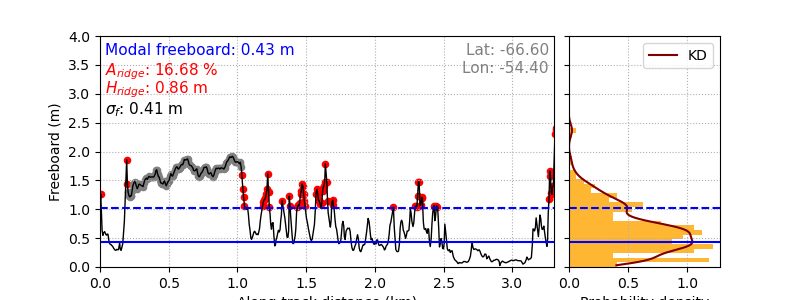

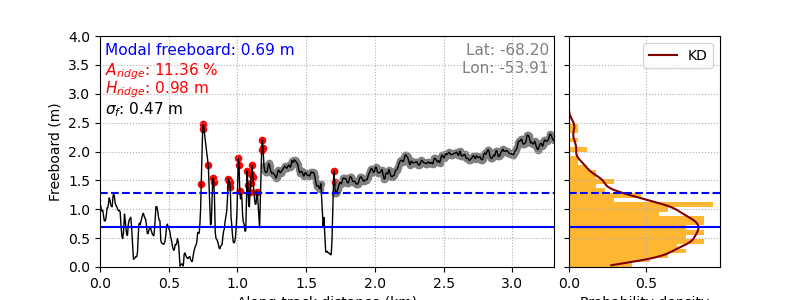

In [207]:
for N in [1190, 1020]: #1190, 1020, 1101

    fig, ax = plt.subplots(1,2, figsize = (8, 3), dpi = 100, gridspec_kw={'width_ratios': [3, 1]}, sharey = True)
    plt.subplots_adjust(hspace=0.05, wspace=0.05)

    idx = (df['beam'] == beam) & (df['sample_ndx'] == N) # 140    
    idx2 = (df['beam'] == beam) & (df['sample_ndx'] == N) & (df['ib_mask'] == 0) # 140
    idx_ib = (df['beam'] == beam) & (df['sample_ndx'] == N) & (df['ib_mask'] == 1) # 140
    
    data = df['fb'][idx2].values
    x_d, logprob, mode = calculate_mode2(data)
    
    idx_ridge = idx2 & (df['fb'] > mode + 0.6)
    x_min = np.min(df['seg_x'][idx]/1000)
    ax[0].plot(df['seg_x'][idx]/1000 - x_min, df['fb'][idx], color = 'k', lw = 1)
    ax[0].plot(df['seg_x'][idx]/1000 - x_min, df['seg_x'][idx]*0 + mode, color = "b")
    ax[0].plot(df['seg_x'][idx]/1000 - x_min, df['seg_x'][idx]*0 + mode + 0.6, color = "b", ls = "--")
    ax[0].scatter(df['seg_x'][idx_ridge]/1000 - x_min, df['fb'][idx_ridge], color = "r", s = 20)
    ax[0].scatter(df['seg_x'][idx_ib]/1000 - x_min, df['fb'][idx_ib], color = "gray", s = 20)
    ax[0].set_xlim(0, 3.3)
    ax[0].set_xlabel('Along-track distance (km)')
    ax[0].set_ylabel('Freeboard (m)')
    ax[0].grid(ls = ":", lw = 0.8)
    ax[0].annotate(f"Modal freeboard: {mode:.2f} m", xy = (0.01, 0.97), xycoords='axes fraction',
                   ha = "left", va = "top", fontsize = 11, color = "b")
    
    # ax[0].annotate(f"Mode: {mode}", xy = (0.01, 0.90), xycoords='axes fraction', ha = "left", va = "top", fontsize = 11)
    
    rf = np.sum(df['seg_len'][idx_ridge]) / np.sum(df['seg_len'][idx2]) * 100
    rh = np.mean(df['fb'][idx_ridge]) - mode
    sdf = np.std(df['fb'][idx2])
    pos_lat = np.mean(df['lat'][idx])
    pos_lon = np.mean(df['lon'][idx])
    
    ax[0].annotate("$A_{ridge}$" + f": {rf:.2f} %", xy = (0.01, 0.89), xycoords='axes fraction',
                   ha = "left", va = "top", fontsize = 11, color = "r")
    ax[0].annotate("$H_{ridge}$" + f": {rh:.2f} m", xy = (0.01, 0.81), xycoords='axes fraction',
                   ha = "left", va = "top", fontsize = 11, color = "r")
    ax[0].annotate("$\sigma_{f}$" + f": {sdf:.2f} m", xy = (0.01, 0.72), xycoords='axes fraction',
                   ha = "left", va = "top", fontsize = 11, color = "k")

    ax[0].annotate("Lat" + f": {pos_lat:.2f}", xy = (0.99, 0.97), xycoords='axes fraction',
                   ha = "right", va = "top", fontsize = 11, color = "gray")
    ax[0].annotate("Lon" + f": {pos_lon:.2f}", xy = (0.99, 0.89), xycoords='axes fraction',
                   ha = "right", va = "top", fontsize = 11, color = "gray")
    
    ax[1].hist(data, density = True, range = (0,4), bins = 50, orientation = "horizontal", color = "orange", alpha = 0.8)
    ax[1].plot(np.exp(logprob), x_d + w/2, color = "maroon", label = "KD")
    ax[1].axhline(mode, color = "b")
    ax[1].axhline(mode + 0.6, color = "b", ls = "--")
    ax[1].set_ylim(0, 4.0)
    ax[1].set_xlabel('Probability density')
    ax[1].grid(ls = ":", lw = 0.8)
    ax[1].legend()

    prf_name = os.path.basename(filename).replace('_006_02.h5', beam + str(int(N)) + "_corrected.png")
    plt.savefig("D:\\Documents\\Submit_paper\\Landfast_Weddell\\{0}.png".format(prf_name), bbox_inches="tight")

In [104]:
df[(df['seg_x'] < 533000) & (df['seg_x'] > 524000)]

,beam,lat,lon,seg_x,seg_len,fb,ph_rate,sigma,stype,refsur_ndx,sample_ndx,fb_std,fb_mode,ridge,ib_mask
43003,gt3r,-67.417090,-54.157516,524000.466847,11.378487,1.054894,8.294118,0.009956,1,110,1100.0,0.036949,0.467143,0.0,1
43004,gt3r,-67.417043,-54.157531,524005.724325,10.667204,1.005909,9.187500,0.011023,1,110,1100.0,0.030512,0.467143,0.0,1
43005,gt3r,-67.417001,-54.157543,524010.434361,11.374260,0.998886,8.823529,0.011865,1,110,1100.0,0.026248,0.467143,0.0,1
43006,gt3r,-67.416942,-54.157561,524017.083267,12.081363,1.047452,7.944445,0.010356,1,110,1100.0,0.069327,0.467143,0.0,1
43007,gt3r,-67.416889,-54.157577,524022.982001,12.790583,1.135641,7.578948,0.010393,1,110,1100.0,0.070534,0.467143,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44530,gt3r,-67.337176,-54.181964,532974.084791,11.395561,1.075219,8.294118,0.009914,1,110,1102.0,0.035074,0.481429,0.0,1
44531,gt3r,-67.337127,-54.181979,532979.573744,11.391983,1.072336,8.352942,0.010208,1,110,1102.0,0.022116,0.481429,0.0,1
44532,gt3r,-67.337074,-54.181995,532985.556109,12.809834,1.112001,7.578948,0.011341,1,110,1102.0,0.035821,0.481429,1.0,1
44533,gt3r,-67.337011,-54.182014,532992.625851,12.803640,1.143835,7.631579,0.009721,1,110,1102.0,0.017186,0.481429,1.0,1


## Figures for Floes paper

In [102]:
year = 2019
df_all = pd.read_csv(f"D:\\Floes\\icebergs\\Icebergs_{region}_{year}_sigma{th_sigma}_std{th_std}.csv", index_col = 0)

bbox = [-65, -77.6, -15, -62]

In [103]:
df_all.head(5)

,filename,beam,beam_num,year,month,day,lat,lon,seg_x,id_st,id_en,fb_mean,fb_max,fb_min,fb_std,width
0,ATL10-02_20190106015150_01320201_006_02.h5,gt1l,2,2019,1,6,-74.696045,-58.104172,2.840756e+07,41937.0,41939.0,3.286645,4.139675,0.803014,1.655887,2962.105518
1,ATL10-02_20190128125318_04750201_006_02.h5,gt3l,2,2019,1,28,-77.048003,-45.411343,3.153924e+07,4889.0,4891.0,2.815334,3.749400,0.073831,1.827727,364.688665
2,ATL10-02_20190201124501_05360201_006_02.h5,gt1l,2,2019,2,1,-77.457868,-46.145792,3.149398e+07,2.0,218.0,2.208784,4.795080,1.040448,0.706147,1262.228372
3,ATL10-02_20190201124501_05360201_006_02.h5,gt3l,2,2019,2,1,-77.478857,-45.845838,3.149040e+07,103.0,169.0,1.534435,1.986665,1.192618,0.179018,357.599200
4,ATL10-02_20190201234503_05430201_006_02.h5,gt1l,2,2019,2,1,-76.910373,-47.072810,2.865782e+07,86533.0,86596.0,3.581594,3.901320,3.243701,0.100923,360.053550


In [105]:
df_count = df_all.groupby('filename').count()

In [131]:
files = df_count.sort_values(by = "lat", ascending = False).loc[:, ['beam']].head(12).index.unique().sort_values()

In [133]:
files

Index(['ATL10-02_20190310110421_11000201_006_02.h5',
       'ATL10-02_20190310220423_11070201_006_02.h5',
       'ATL10-02_20190518191658_07720301_006_02.h5',
       'ATL10-02_20190522190837_08330301_006_02.h5',
       'ATL10-02_20190530185156_09550301_006_02.h5',
       'ATL10-02_20190621061857_12830301_006_02.h5',
       'ATL10-02_20190731155540_05130401_006_02.h5',
       'ATL10-02_20190902142326_10160401_006_02.h5',
       'ATL10-02_20190906141506_10770401_006_02.h5',
       'ATL10-02_20191005125113_01320501_006_02.h5',
       'ATL10-02_20191019003453_03380501_006_02.h5',
       'ATL10-02_20191227084738_00100601_006_01.h5'],
      dtype='object', name='filename')

In [70]:
n = 8
filename = "D:\\Floes\\ATL10\\" + files[n]
beam_nums = df_all.loc[df_all['filename'] == files[n], "beam_num"].unique()
print(filename, beam_nums)

D:\Floes\ATL10\ATL10-02_20190127004437_04520201_006_02.h5 [0]


In [71]:
filename = "D:\\Floes\\ATL10\\" + files[n]
beam_num = 0

with h5py.File(filename,'r') as f:
    # print(filename)
    # Check the orbit orientation
    orient = f['orbit_info/sc_orient'][0]
    strong_beams = []

    if orient == 0:
        for i in [1, 2, 3]:
            if f"gt{i}l" in f.keys():
                strong_beams.append(f"gt{i}l")
    elif orient == 1:
        for i in [1, 2, 3]:
            if f"gt{i}r" in f.keys():
                strong_beams.append(f"gt{i}r")

    for beam in strong_beams[beam_num:beam_num+1]:

        lat = f[beam]['freeboard_segment/latitude'][:]
        lon = f[beam]['freeboard_segment/longitude'][:]
        fb = f[beam]['freeboard_segment/beam_fb_height'][:]

        idx = (lat >= bbox[1]) & (lat <= bbox[3]) & (lon >= bbox[0]) & (lon <= bbox[2]) & (fb <= 10)

        lat = lat[idx]
        lon = lon[idx]
        fb = fb[idx]

        seg_x = f[beam]['freeboard_segment/seg_dist_x'][idx] # (m to km)
        seg_len = f[beam]['freeboard_segment/heights/height_segment_length_seg'][idx]
        ph_rate = f[beam]['freeboard_segment/heights/photon_rate'][idx]
        sigma = f[beam]['freeboard_segment/heights/height_segment_sigma'][idx]
        fb[fb > 100] = np.nan
        stype = f[beam]['freeboard_segment/heights/height_segment_type'][idx]
        refsur_ndx = f[beam]['freeboard_segment/beam_refsurf_ndx'][idx]
        fb_std = pd.Series(fb).rolling(3, center = True).std().values

        df = pd.DataFrame({'lat': lat, 'lon': lon, 'seg_x': seg_x, 'seg_len': seg_len, 'fb': fb, 'ph_rate': ph_rate, 'sigma': sigma})

        ib_mask = (fb > 1.0) & (sigma < 0.03) & (fb_std < 0.1)
        ib_mask2, df_ib = determine_iceberg(df, ib_mask)
        df_ib2, ib_mask3 = combine_icebergs(df, df_ib, ib_mask2)

print(filename)

D:\Floes\ATL10\ATL10-02_20190127004437_04520201_006_02.h5


In [72]:
df_ib2

,lat,lon,seg_x,id_st,id_en,fb_mean,fb_max,fb_min,fb_std,width
0,-67.854187,-53.472409,2.763767e+07,56237.0,56342.0,1.552851,2.13494,1.013791,0.272408,652.142155


D:\Floes\ATL10\ATL10-02_20190127004437_04520201_006_02.h5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


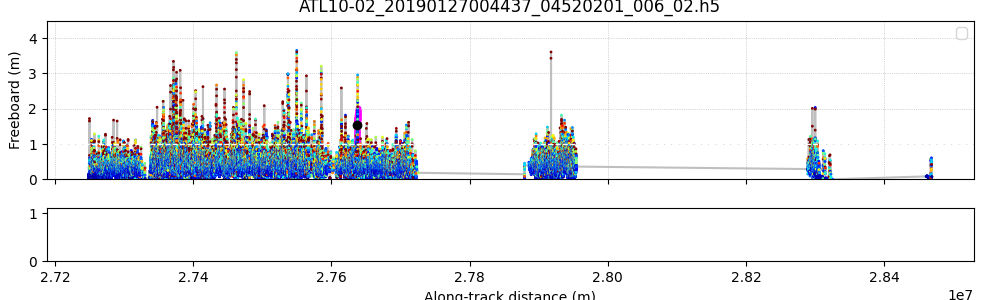

In [75]:
%matplotlib widget
print(filename)
fig, ax = plt.subplots(2,1, figsize = (10, 3), gridspec_kw={'height_ratios': [3, 1]}, sharex = True)
fig.tight_layout()

# pm = ax[0].pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax[0].plot(seg_x, fb, c="gray", zorder=1, alpha = 0.5)
sc = ax[0].scatter(seg_x, fb, c=fb_std, s= 1, cmap = "jet", vmax = 0.2, zorder = 2) # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02, zorder = 2) # std. freeboard nearby

# sc = ax[0].scatter(seg_x[ib_mask], fb[ib_mask], s= 2, c = "yellow", zorder = 6) # std. freeboard nearby
sc = ax[0].scatter(seg_x[ib_mask3], fb[ib_mask3], s= 10, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma

ax[0].errorbar(df_ib2['seg_x'], df_ib2['fb_mean'], xerr = df_ib2['width']/2, fmt ='o', color = "k")
# fig.colorbar(sc)
ax[0].legend()
# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax[0].axhline(1, ls = "--", lw = 1, c="w", zorder=2)

ax[0].set_title(os.path.basename(filename))
ax[0].grid(ls = ":", lw = 0.5)

ax[0].set_ylabel("Freeboard (m)");

# ax[0].set_xlim(32614*1000, 32617*1000);
# ax[0].set_xlim(32540*1000, 32620*1000);
# ax[0].set_xlim(32560*1000, 32580*1000);
# ax[0].set_xlim(32540*1000, 32560*1000);
# ax[0].set_xlim(32872.5*1000, 32882.5*1000);
# ax[0].set_xlim(32697.5*1000, 32705*1000);
# ax[0].set_xlim(32660.5*1000, 32680*1000);
# ax[0].set_xlim(32660.5*1000, 32680*1000);

# ax[0].set_xlim(seg_x[int(df_ib2.loc[0, 'id_st'])]-1000, seg_x[int(df_ib2['id_st'].values[-1])]+1000);
ax[0].set_ylim(0, 4.5);

# a = np.sum(ratio[5:, ], axis = 0)
# ax[1].scatter(xx[0, :], a, c = a)
ax[1].set_ylim(0.0, 1.1)
ax[1].set_xlabel("Along-track distance (m)")

plt.show()
# plt.close()

## Figures for iceberg detection

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


D:\Floes\ATL10\ATL10-02_20191023002635_03990501_006_02.h5


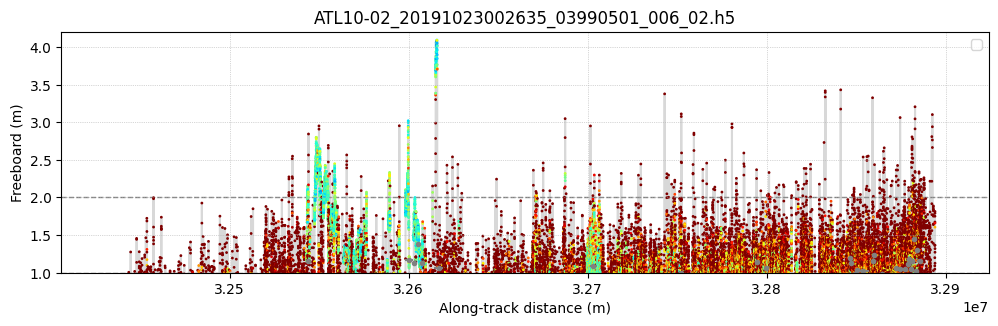

In [153]:
%matplotlib inline
print(filename)
fig, ax = plt.subplots(1,1, figsize = (10, 3))
fig.tight_layout()
ax.plot(seg_x, fb, c="gray", zorder=1, alpha = 0.3)
# ax.scatter(seg_x, fb, c=bck, s= 1, cmap = "jet", vmax = 500000) # background rate
# ax.scatter(seg_x, fb, c=asr, s= 1, cmap = "jet", vmax = 0.7, vmin = 0.6) # surface reflectance
ax.scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma
# ax.scatter(seg_x, fb, c=ph_rate, s= 1, cmap = "jet", vmax = 10, vmin = 5) # photon rate
# plt.scatter(floe_loc0, fb_mean0, s = 1, c = "k")
ax.errorbar(floe_loc0, fb_mean0, xerr = floe_len0/2, fmt ='.', color = "gray")
# ax.scatter(lead_pos0, lead_pos0*0, c= "k", s= 20, label = "leads")
ax.legend()
ax.axhline(1, ls = "--", lw = 1, c="k", zorder=0, alpha = 0.5)
ax.axhline(2, ls = "--", lw = 1, c="k", zorder=0, alpha = 0.5)

ax.set_title(os.path.basename(filename))
ax.grid(ls = ":", lw = 0.5)
ax.set_xlabel("Along-track distance (m)")
ax.set_ylabel("Freeboard (m)");

# ax[0].set_xlim(32614*1000, 32617*1000);
# ax.set_xlim(32540*1000, 32560*1000);
ax.set_ylim(1, 4.2);

plt.show()
# plt.close()

In [532]:
seg_x.max() - seg_x.min()

space = 1000
space_fb = 0.2

bin_seg_x = np.arange(np.floor(seg_x.min()/space)*space, np.floor(seg_x.max()/space)*space + space, space)
bin_fb = np.arange(0,5+space_fb, space_fb)

In [533]:
xx, yy = np.meshgrid(bin_seg_x + space/2, bin_fb + space_fb/2)
count = np.zeros(xx.shape)
ratio = np.zeros(xx.shape)
filter = np.zeros(xx.shape)

for i in range(0, xx.shape[0]-1):
    for j in range(0, xx.shape[1]-1):
        count[i, j] = np.sum((seg_x >= bin_seg_x[j]) & (seg_x < bin_seg_x[j+1]) & (fb >= bin_fb[i]) & (fb < bin_fb[i+1]))

ratio = count / np.sum(count, axis=0)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


D:\Floes\ATL10\ATL10-02_20191023002635_03990501_006_02.h5


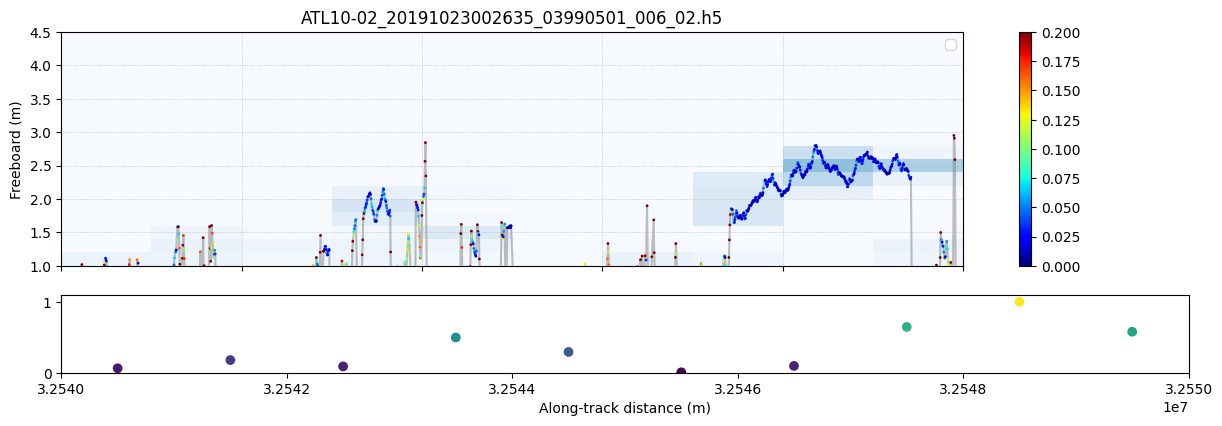

In [255]:
%matplotlib inline
print(filename)
fig, ax = plt.subplots(2,1, figsize = (12, 4), gridspec_kw={'height_ratios': [3, 1]}, sharex = True)
fig.tight_layout()

pm = ax[0].pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax[0].plot(seg_x, fb, c="gray", zorder=1, alpha = 0.5)
sc = ax[0].scatter(seg_x, fb, c=fb_std, s= 1, cmap = "jet", vmax = 0.2, zorder = 5) # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma
fig.colorbar(sc)
ax[0].legend()
# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax[0].axhline(1, ls = "--", lw = 1, c="w", zorder=2)

ax[0].set_title(os.path.basename(filename))
ax[0].grid(ls = ":", lw = 0.5)

ax[0].set_ylabel("Freeboard (m)");

# ax[0].set_xlim(32614*1000, 32617*1000);
# ax[0].set_xlim(32540*1000, 32560*1000);
ax[0].set_xlim(32540*1000, 32550*1000);
# ax[0].set_xlim(32872.5*1000, 32882.5*1000);
ax[0].set_ylim(1, 4.5);

a = np.sum(ratio[5:, ], axis = 0)
ax[1].scatter(xx[0, :], a, c = a)
ax[1].set_ylim(0.0, 1.1)
ax[1].set_xlabel("Along-track distance (m)")

plt.show()
# plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


D:\Floes\ATL10\ATL10-02_20191005125113_01320501_006_02.h5


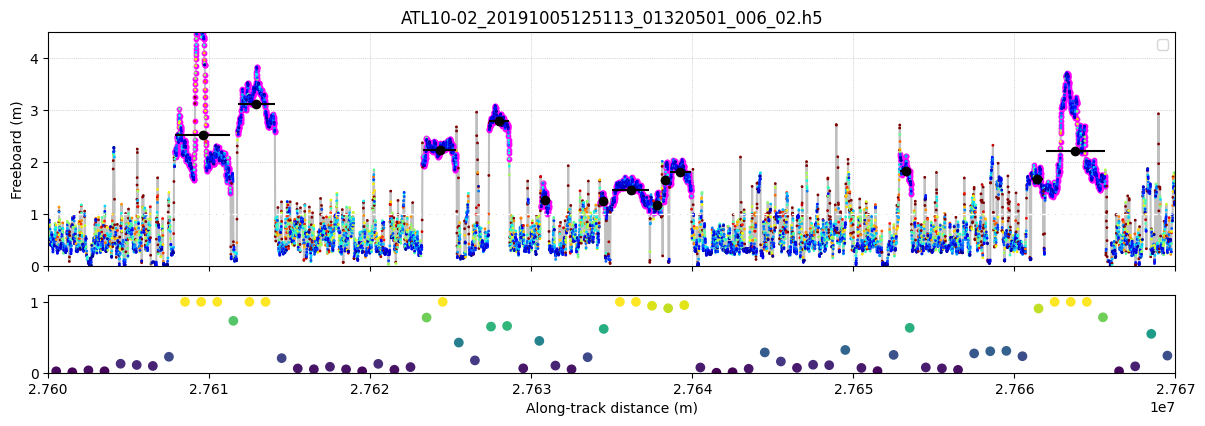

In [651]:
%matplotlib inline
print(filename)
fig, ax = plt.subplots(2,1, figsize = (12, 4), gridspec_kw={'height_ratios': [3, 1]}, sharex = True)
fig.tight_layout()

# pm = ax[0].pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax[0].plot(seg_x, fb, c="gray", zorder=1, alpha = 0.5)
sc = ax[0].scatter(seg_x, fb, c=fb_std, s= 1, cmap = "jet", vmax = 0.2, zorder = 2) # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02, zorder = 2) # std. freeboard nearby

# sc = ax[0].scatter(seg_x[ib_mask], fb[ib_mask], s= 2, c = "yellow", zorder = 6) # std. freeboard nearby
sc = ax[0].scatter(seg_x[ib_mask3], fb[ib_mask3], s= 10, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma

ax[0].errorbar(df_ib2['seg_x'], df_ib2['fb_mean'], xerr = df_ib2['width']/2, fmt ='o', color = "k")
# fig.colorbar(sc)
ax[0].legend()
# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax[0].axhline(1, ls = "--", lw = 1, c="w", zorder=2)

ax[0].set_title(os.path.basename(filename))
ax[0].grid(ls = ":", lw = 0.5)

ax[0].set_ylabel("Freeboard (m)");

# ax[0].set_xlim(32614*1000, 32617*1000);
# ax[0].set_xlim(32540*1000, 32620*1000);
# ax[0].set_xlim(32560*1000, 32580*1000);
# ax[0].set_xlim(32540*1000, 32560*1000);
# ax[0].set_xlim(32872.5*1000, 32882.5*1000);
# ax[0].set_xlim(32697.5*1000, 32705*1000);
# ax[0].set_xlim(32660.5*1000, 32680*1000);
# ax[0].set_xlim(32660.5*1000, 32680*1000);

ax[0].set_xlim(27600*1000, 27670*1000);
ax[0].set_ylim(0, 4.5);

a = np.sum(ratio[5:, ], axis = 0)
ax[1].scatter(xx[0, :], a, c = a)
ax[1].set_ylim(0.0, 1.1)
ax[1].set_xlabel("Along-track distance (m)")

plt.show()
# plt.close()

In [642]:
ib_mask3

array([False, False, False, ..., False, False, False])

In [641]:
df_ib2

,lat,lon,seg_x,id_st,id_en,fb_mean,fb_max,fb_min,fb_std,width
8,-66.758148,-55.075900,2.751517e+07,66545.0,66591.0,1.774768,1.986350,1.051248,0.171473,307.849823
10,-67.599186,-55.326757,2.760959e+07,75612.0,76136.0,2.517295,4.679867,0.365546,0.924735,3449.202316
11,-67.628813,-55.335948,2.761292e+07,76194.0,76546.0,3.113596,3.825711,2.528698,0.288546,2304.830171
12,-67.730180,-55.367825,2.762431e+07,77882.0,78199.0,2.236157,2.460335,1.843640,0.129044,2079.363266
13,-67.763130,-55.377931,2.762801e+07,78482.0,78671.0,2.781950,3.084039,1.955690,0.153398,1230.300540
14,-67.788493,-55.385646,2.763085e+07,78959.0,79031.0,1.256609,1.600289,0.660537,0.157481,482.430888
15,-67.820366,-55.395375,2.763443e+07,79490.0,79535.0,1.251099,1.403426,0.189387,0.179874,297.256535
16,-67.835922,-55.400106,2.763618e+07,79597.0,79947.0,1.456297,1.714460,1.035936,0.155945,2305.428940
18,-67.850279,-55.404459,2.763779e+07,79984.0,80037.0,1.177688,1.415224,1.009412,0.125481,355.310391
19,-67.855103,-55.405939,2.763833e+07,80069.0,80113.0,1.646357,1.991160,1.235387,0.274014,291.159064


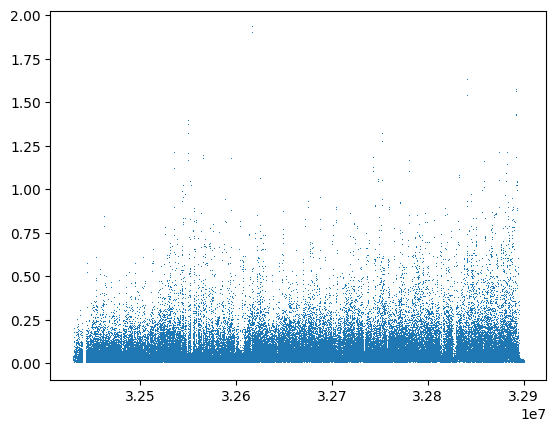

In [189]:
fb_std = pd.Series(fb).rolling(3).std().values
plt.plot(seg_x, fb_std, ',')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


D:\Floes\ATL10\ATL10-02_20191023002635_03990501_006_02.h5


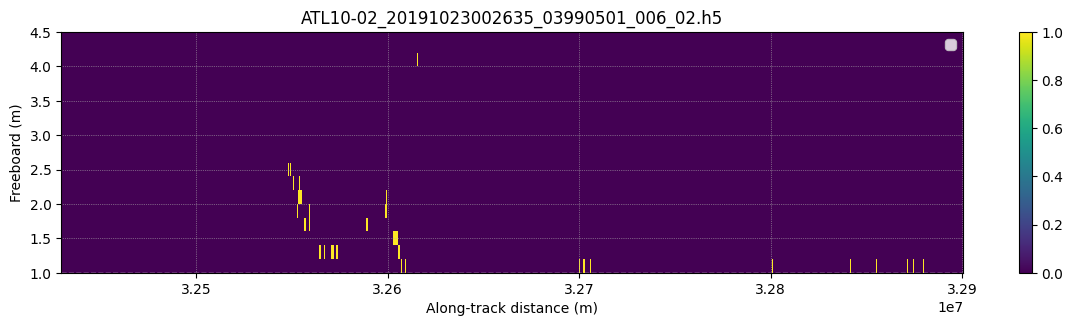

In [182]:
%matplotlib inline

filter[ratio > 0.4] = 1


print(filename)
fig, ax = plt.subplots(1,1, figsize = (12, 3))
fig.tight_layout()
pm = ax.pcolormesh(xx, yy, filter, zorder = 0)
# sc = ax.scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02, zorder = 5) # sigma
fig.colorbar(pm)
ax.legend()
# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)

ax.set_title(os.path.basename(filename))
ax.grid(ls = ":", lw = 0.5)
ax.set_xlabel("Along-track distance (m)")
ax.set_ylabel("Freeboard (m)");

# ax.set_xlim(32614*1000, 32617*1000);
# ax.set_xlim(32540*1000, 32560*1000);
# ax.set_xlim(32840*1000, 32895*1000);
ax.set_ylim(1, 4.5);

plt.show()
# plt.close()

In [19]:
with h5py.File(filename,'r') as f:
    # print(filename)
    # Check the orbit orientation
    orient = f['orbit_info/sc_orient'][0]
    strong_beams = []

    if orient == 0:
        for i in [1, 2, 3]:
            if f"gt{i}l" in f.keys():
                strong_beams.append(f"gt{i}l")
    elif orient == 1:
        for i in [1, 2, 3]:
            if f"gt{i}r" in f.keys():
                strong_beams.append(f"gt{i}r")

    for beam in strong_beams[beam_num:beam_num+1]:

        lat = f[beam]['freeboard_segment/latitude'][:]
        lon = f[beam]['freeboard_segment/longitude'][:]
        fb = f[beam]['freeboard_segment/beam_fb_height'][:]

        idx = (lat >= bbox[1]) & (lat <= bbox[3]) & (lon >= bbox[0]) & (lon <= bbox[2])

        lat = lat[idx]
        lon = lon[idx]
        fb = fb[idx]

        seg_x = f[beam]['freeboard_segment/seg_dist_x'][idx] # (m to km)
        seg_len = f[beam]['freeboard_segment/heights/height_segment_length_seg'][idx]
        ph_rate = f[beam]['freeboard_segment/heights/photon_rate'][idx]
        sigma = f[beam]['freeboard_segment/heights/height_segment_sigma'][idx]
        asr = f[beam]['freeboard_segment/heights/asr_25'][idx]
        bck = f[beam]['freeboard_segment/heights/background_r_norm'][idx]
        rms = f[beam]['freeboard_segment/heights/height_segment_rms'][idx]
        fb[fb > 100] = np.nan
        stype = f[beam]['freeboard_segment/heights/height_segment_type'][idx]
        refsur_ndx = f[beam]['freeboard_segment/beam_refsurf_ndx'][idx]

        print(f[beam]['freeboard_segment/heights'].keys())

<KeysViewHDF5 ['asr_25', 'backgr_calc', 'backgr_r_200', 'backgr_r_25', 'background_r_norm', 'bsnow_con', 'bsnow_h', 'cloud_flag_asr', 'cloud_flag_atm', 'delta_time', 'height_segment_confidence', 'height_segment_dist2land', 'height_segment_height', 'height_segment_length_seg', 'height_segment_ocdepth', 'height_segment_rms', 'height_segment_sigma', 'height_segment_ssh_flag', 'height_segment_type', 'height_segment_w_gaussian', 'ice_conc_amsr2', 'ice_conc_ssmi', 'latitude', 'layer_flag', 'longitude', 'msw_flag', 'photon_rate', 'podppd_flag']>


In [155]:
X

array([ 3.61268028e-09+0.00000000e+00j,  1.25966509e+03+7.43072867e+04j,
        1.53982402e+03+3.78706580e+04j, ...,
       -3.45859673e+00-4.56488630e-02j, -3.45279132e+00-2.90427881e-02j,
       -3.45105987e+00-5.86040679e-03j])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


D:\Floes\ATL10\ATL10-02_20191023002635_03990501_006_02.h5


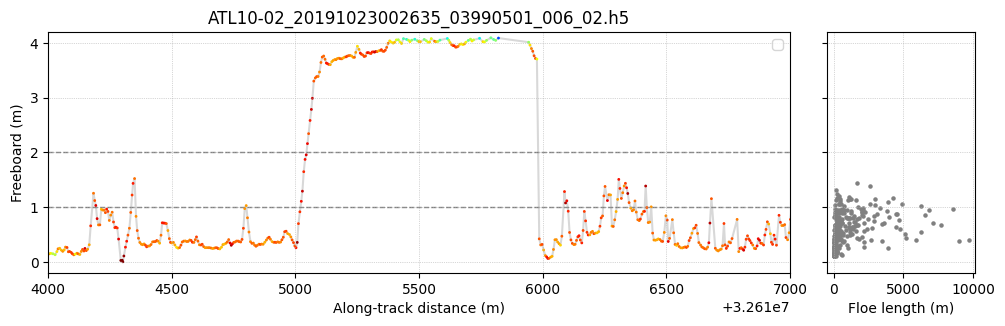

In [160]:
%matplotlib inline
print(filename)
fig, ax = plt.subplots(1,2, figsize = (10, 3), gridspec_kw={'width_ratios': [5, 1]}, sharey = True)
fig.tight_layout()
ax[0].plot(seg_x, fb, c="gray", zorder=1, alpha = 0.3)
ax[0].plot(year + spots.mean(), spots)
# ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma
ax[0].scatter(seg_x, fb, c=ph_rate, s= 1, cmap = "jet", vmax = 10) # photon rate

ax[0].legend()
ax[0].axhline(1, ls = "--", lw = 1, c="k", zorder=0, alpha = 0.5)
ax[0].axhline(2, ls = "--", lw = 1, c="k", zorder=0, alpha = 0.5)

ax[0].set_title(os.path.basename(filename))
ax[0].grid(ls = ":", lw = 0.5)
ax[0].set_xlabel("Along-track distance (m)")
ax[0].set_ylabel("Freeboard (m)");

ax[0].set_xlim(32614*1000, 32617*1000);
# ax[0].set_xlim(32598*1000, 32609*1000);
ax[0].set_ylim(-0.2, 4.2);

ax[1].scatter(floe_len0, fb_mean0, s = 5, c = "gray")
ax[1].grid(ls = ":", lw = 0.5)
ax[1].set_xlabel("Floe length (m)")
# ax[1].set_xscale('log')

plt.show()
# plt.close()

In [3]:
year = 2019
df_all = pd.read_csv(f"D:\\Floes\\icebergs\\Icebergs_{year}.csv", index_col = 0)

bbox = [-65, -77.6, -15, -62]

In [19]:
df_all.head(5)

,filename,beam,beam_num,year,month,day,lat,lon,seg_x,id_st,id_en,fb_mean,fb_max,fb_min,fb_std,width
0,ATL10-02_20190106015150_01320201_006_02.h5,gt1l,0,2019,1,6,-74.601091,-58.051187,2.839684e+07,40357.0,40441.0,3.382634,3.622471,2.905646,0.162428,467.942822
1,ATL10-02_20190106015150_01320201_006_02.h5,gt1l,0,2019,1,6,-74.698437,-58.105523,2.840783e+07,41940.0,42035.0,3.659101,4.088406,0.090341,0.389613,1376.631922
2,ATL10-02_20190106015150_01320201_006_02.h5,gt2l,1,2019,1,6,-74.592710,-58.161513,2.839640e+07,32842.0,32881.0,2.973534,3.092570,2.750389,0.092182,273.630694
3,ATL10-02_20190106015150_01320201_006_02.h5,gt2l,1,2019,1,6,-74.691138,-58.217169,2.840750e+07,34142.0,34726.0,3.707140,4.193796,2.539752,0.277467,4100.056202
4,ATL10-02_20190106142608_01400201_006_02.h5,gt1l,0,2019,1,6,-76.182618,-53.830011,3.163831e+07,20.0,145.0,2.378184,3.122895,1.873965,0.362548,675.041457


In [86]:
ib_count = df_all.groupby('filename', as_index = False).count()

In [87]:
ib_count[ib_count["beam"] > 10]

,filename,beam,beam_num,year,month,day,lat,lon,seg_x,id_st,id_en,fb_mean,fb_max,fb_min,fb_std,width
11,ATL10-02_20190201234503_05430201_006_02.h5,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19
12,ATL10-02_20190205233644_06040201_006_02.h5,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46
16,ATL10-02_20190219112019_08100201_006_02.h5,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
26,ATL10-02_20190302222103_09850201_006_02.h5,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
29,ATL10-02_20190310110421_11000201_006_02.h5,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,ATL10-02_20191120102817_08330501_006_01.h5,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21
290,ATL10-02_20191120230236_08410501_006_01.h5,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
295,ATL10-02_20191124101957_08940501_006_01.h5,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38
302,ATL10-02_20191129094557_09700501_006_01.h5,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13


In [17]:
filename = "D:\\Floes\\ATL10\\ATL10-02_20190310110421_11000201_006_02.h5"
# filename = "D:\\Floes\\ATL10\\ATL10-02_20191023002635_03990501_006_02.h5"
beam_num = 2

bbox = [-65, -77.6, -15, -62]

with h5py.File(filename,'r') as f:
    # print(filename)
    # Check the orbit orientation
    orient = f['orbit_info/sc_orient'][0]
    strong_beams = []

    if orient == 0:
        for i in [1, 2, 3]:
            if f"gt{i}l" in f.keys():
                strong_beams.append(f"gt{i}l")
    elif orient == 1:
        for i in [1, 2, 3]:
            if f"gt{i}r" in f.keys():
                strong_beams.append(f"gt{i}r")

    for beam in strong_beams[beam_num:beam_num+1]:

        lat = f[beam]['freeboard_segment/latitude'][:]
        lon = f[beam]['freeboard_segment/longitude'][:]
        fb = f[beam]['freeboard_segment/beam_fb_height'][:]

        idx = (lat >= bbox[1]) & (lat <= bbox[3]) & (lon >= bbox[0]) & (lon <= bbox[2]) & (fb <= 10)

        lat = lat[idx]
        lon = lon[idx]
        fb = fb[idx]

        seg_x = f[beam]['freeboard_segment/seg_dist_x'][idx] # (m to km)
        seg_len = f[beam]['freeboard_segment/heights/height_segment_length_seg'][idx]
        ph_rate = f[beam]['freeboard_segment/heights/photon_rate'][idx]
        sigma = f[beam]['freeboard_segment/heights/height_segment_sigma'][idx]
        fb[fb > 100] = np.nan
        stype = f[beam]['freeboard_segment/heights/height_segment_type'][idx]
        refsur_ndx = f[beam]['freeboard_segment/beam_refsurf_ndx'][idx]
        fb_std = pd.Series(fb).rolling(3, center = True).std().values

        df = pd.DataFrame({'lat': lat, 'lon': lon, 'seg_x': seg_x, 'seg_len': seg_len, 'fb': fb,
                           'fb_std': fb_std, 'ph_rate': ph_rate, 'sigma': sigma})

        # ib_mask = (fb > 1.0) & (sigma < 0.03) & (fb_std < 0.1)
        ib_mask2, df_ib = determine_iceberg(df, th_fb = 0.8, th_sigma = 0.02, th_std = 0.1)
        df_ib2, ib_mask3 = combine_icebergs(df, df_ib, ib_mask2, th_fb = 0.8)

print(filename)

D:\Floes\ATL10\ATL10-02_20190310110421_11000201_006_02.h5


D:\Floes\ATL10\ATL10-02_20190310110421_11000201_006_02.h5


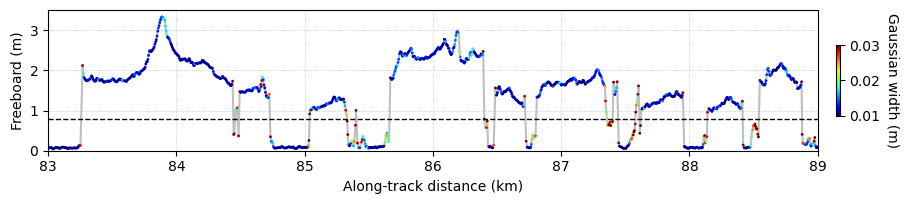

In [18]:
# %matplotlib widget
print(filename)
fig, ax = plt.subplots(1,1, figsize = (10, 2), dpi = 100, sharex = True)
fig.tight_layout()
seg_x_km = (seg_x - seg_x.min()) / 1000

# pm = ax[0].pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax.plot(seg_x_km, fb, c="gray", zorder=1, alpha = 0.5)
# sc = ax.scatter(seg_x_km, fb, c=fb_std, s= 1, cmap = "jet", vmax = 0.2, zorder = 2) # std. freeboard nearby
sc = ax.scatter(seg_x_km, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.03, vmin = 0.01, zorder = 2) # std. freeboard nearby

# sc = ax[0].scatter(seg_x[ib_mask], fb[ib_mask], s= 2, c = "yellow", zorder = 6) # std. freeboard nearby
# sc = ax.scatter(seg_x_km[ib_mask3], fb[ib_mask3], s= 10, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma

# ax.errorbar(df_ib2['seg_x'], df_ib2['fb_mean'], xerr = df_ib2['width']/2, fmt ='o', color = "k")
cb = fig.colorbar(sc, pad = 0.02, shrink = 0.5)
cb.set_label(f"Gaussian width (m)", rotation = 270, va = "bottom")
# ax.legend()
# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax.axhline(0.8, ls = "--", lw = 1, c="k", zorder=2)

# ax.set_title(os.path.basename(filename))
ax.grid(ls = ":", lw = 0.5)

ax.set_ylabel("Freeboard (m)");
ax.set_xlabel("Along-track distance (km)");

# ax[0].set_xlim(seg_x[int(df_ib2.loc[0, 'id_st'])]-1000, seg_x[int(df_ib2['id_st'].values[-1])]+1000);
ax.set_ylim(0, 3.5);
ax.set_xlim(83, 89);

plt.show()
# plt.close()

D:\Floes\ATL10\ATL10-02_20190310110421_11000201_006_02.h5


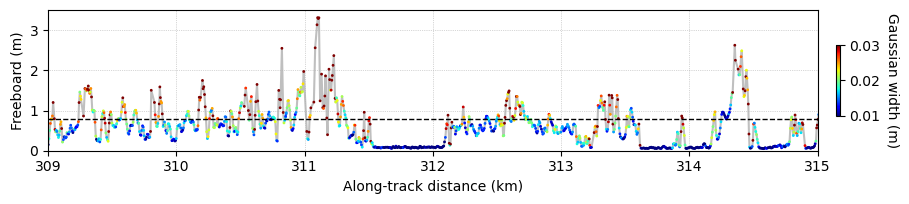

In [20]:
# %matplotlib widget
print(filename)
fig, ax = plt.subplots(1,1, figsize = (10, 2), dpi = 100, sharex = True)
fig.tight_layout()
seg_x_km = (seg_x - seg_x.min()) / 1000

# pm = ax[0].pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax.plot(seg_x_km, fb, c="gray", zorder=1, alpha = 0.5)
# sc = ax.scatter(seg_x_km, fb, c=fb_std, s= 1, cmap = "jet", vmax = 0.2, zorder = 2) # std. freeboard nearby
sc = ax.scatter(seg_x_km, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.03, vmin = 0.01, zorder = 2) # std. freeboard nearby

# sc = ax[0].scatter(seg_x[ib_mask], fb[ib_mask], s= 2, c = "yellow", zorder = 6) # std. freeboard nearby
# sc = ax.scatter(seg_x_km[ib_mask3], fb[ib_mask3], s= 10, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma

# ax.errorbar(df_ib2['seg_x'], df_ib2['fb_mean'], xerr = df_ib2['width']/2, fmt ='o', color = "k")
cb = fig.colorbar(sc, pad = 0.02, shrink = 0.5)
cb.set_label(f"Gaussian width (m)", rotation = 270, va = "bottom")
# ax.legend()
# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax.axhline(0.8, ls = "--", lw = 1, c="k", zorder=2)

# ax.set_title(os.path.basename(filename))
ax.grid(ls = ":", lw = 0.5)

ax.set_ylabel("Freeboard (m)");
ax.set_xlabel("Along-track distance (km)");

# ax[0].set_xlim(seg_x[int(df_ib2.loc[0, 'id_st'])]-1000, seg_x[int(df_ib2['id_st'].values[-1])]+1000);
ax.set_ylim(0, 3.5);
ax.set_xlim(309, 315);

plt.show()

D:\Floes\ATL10\ATL10-02_20190310110421_11000201_006_02.h5


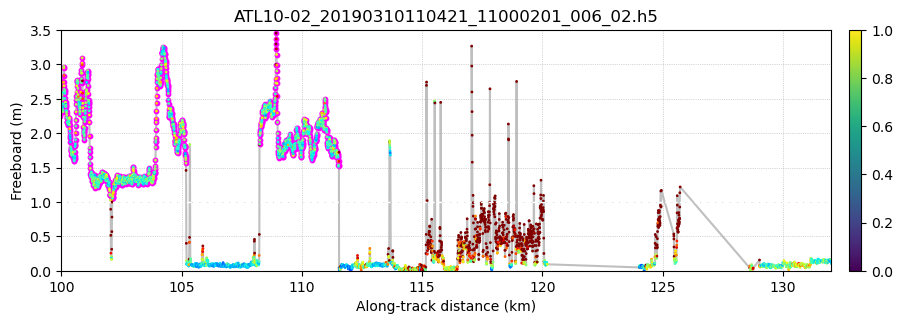

In [82]:
# %matplotlib widget
print(filename)
fig, ax = plt.subplots(1,1, figsize = (10, 3), sharex = True)
fig.tight_layout()
seg_x_km = (seg_x - seg_x.min()) / 1000

# pm = ax[0].pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax.plot(seg_x_km, fb, c="gray", zorder=1, alpha = 0.5)
# sc = ax.scatter(seg_x_km, fb, c=fb_std, s= 1, cmap = "jet", vmax = 0.2, zorder = 2) # std. freeboard nearby
sc = ax.scatter(seg_x_km, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02, zorder = 2) # std. freeboard nearby

# sc = ax[0].scatter(seg_x[ib_mask], fb[ib_mask], s= 2, c = "yellow", zorder = 6) # std. freeboard nearby
sc = ax.scatter(seg_x_km[ib_mask3], fb[ib_mask3], s= 10, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma

# ax.errorbar(df_ib2['seg_x'], df_ib2['fb_mean'], xerr = df_ib2['width']/2, fmt ='o', color = "k")
fig.colorbar(sc, pad = 0.02)
# ax.legend()
# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)

ax.set_title(os.path.basename(filename))
ax.grid(ls = ":", lw = 0.5)

ax.set_ylabel("Freeboard (m)");
ax.set_xlabel("Along-track distance (km)");

# ax[0].set_xlim(32614*1000, 32617*1000);
# ax[0].set_xlim(32540*1000, 32620*1000);
# ax[0].set_xlim(32560*1000, 32580*1000);
# ax[0].set_xlim(32540*1000, 32560*1000);
# ax[0].set_xlim(32872.5*1000, 32882.5*1000);
# ax[0].set_xlim(32697.5*1000, 32705*1000);
# ax[0].set_xlim(32660.5*1000, 32680*1000);
# ax[0].set_xlim(32660.5*1000, 32680*1000);

# ax[0].set_xlim(seg_x[int(df_ib2.loc[0, 'id_st'])]-1000, seg_x[int(df_ib2['id_st'].values[-1])]+1000);
ax.set_ylim(0, 3.5);
ax.set_xlim(100, 132);

plt.show()
# plt.close()